In [1]:
# this code references a movie recommendation system created by Kevin Liao: https://github.com/KevinLiao159/MyDataSciencePortfolio/blob/master/movie_recommender/movie_recommendation_using_KNN.ipynb

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import pandas as pd
from fuzzywuzzy import fuzz
import os
import random as rd
import numpy as np

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [2]:
df_beers = pd.read_csv(
    os.path.join("Resources/beer.csv"),
    usecols=['beer_beerid', 'beer_name'],
    dtype={'beer_beerid': 'int32', 'beer_name': 'str'})

df_ratings = pd.read_csv(
    os.path.join("Resources/beer.csv"),
    usecols=['review_profilename', 'beer_beerid', 'beer_name', 'review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste'],
    dtype={'review_profilename': 'str', 'beer_beerid': 'int32', 'beer_name': 'str', 'review_overall': 'float32', 'review_aroma': 'float32', 'review_appearance': 'float32', 'review_palate': 'float32', 'review_taste': 'float32'})

In [3]:
df_beers_drop_duplicates = df_beers.drop_duplicates()

In [4]:
df_beers_drop_duplicates

,beer_name,beer_beerid
0,Cauldron DIPA,64883
1,Caldera Ginger Beer,52159
10,Caldera Oatmeal Stout,10789
12,Caldera OBF 15,12386
13,Rauch Ür Bock,58046
...,...,...
361227,Unity (2011),75355
361228,Stimulus,72353
361230,Jubilee,64254
361234,Populist IPA In Spanish Cedar,68048


In [5]:
num_reviewers = len(df_ratings.review_profilename.unique())
num_beers = len(df_ratings.beer_beerid.unique())
print('There are {} unique reviewers and {} unique beer in this data set'.format(num_reviewers, num_beers))

There are 18469 unique reviewers and 7300 unique beer in this data set


In [6]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('review_overall').size(), columns=['count'])
df_ratings_cnt_tmp

,count
review_overall,
1.0,1073
1.5,1434
2.0,5445
2.5,9364
3.0,31370
3.5,66898
4.0,142517
4.5,82365
5.0,20775


In [7]:
# there are a lot more counts in rating of zero
total_cnt = num_reviewers * num_beers
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,134462459
1.0,1073
1.5,1434
2.0,5445
2.5,9364
3.0,31370
3.5,66898
4.0,142517
4.5,82365
5.0,20775


In [8]:
# add log count
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,134462459,18.716796
1.0,1073,6.978214
1.5,1434,7.268223
2.0,5445,8.602453
2.5,9364,9.144628
3.0,31370,10.353607
3.5,66898,11.110924
4.0,142517,11.867217
4.5,82365,11.318916
5.0,20775,9.941506


Text(0, 0.5, 'number of ratings')

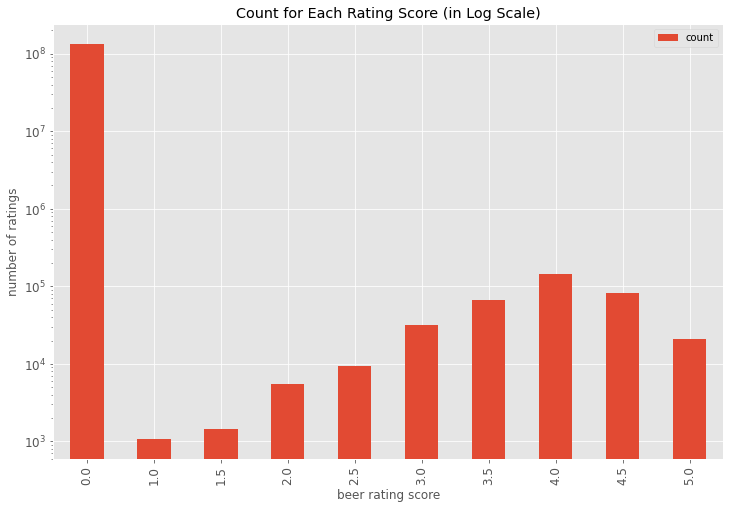

In [9]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("beer rating score")
ax.set_ylabel("number of ratings")

In [10]:
df_ratings.head()

,review_overall,review_aroma,review_appearance,review_profilename,review_palate,review_taste,beer_name,beer_beerid
0,4.0,4.5,4.0,johnmichaelsen,4.0,4.5,Cauldron DIPA,64883
1,3.0,3.5,3.5,oline73,3.0,3.5,Caldera Ginger Beer,52159
2,3.5,3.5,3.5,Reidrover,4.0,4.0,Caldera Ginger Beer,52159
3,3.0,2.5,3.5,alpinebryant,2.0,3.5,Caldera Ginger Beer,52159
4,4.0,3.0,3.5,LordAdmNelson,3.5,4.0,Caldera Ginger Beer,52159


In [11]:
# get rating frequency
df_beer_cnt = pd.DataFrame(df_ratings.groupby('beer_beerid').size(), columns=['count'])
df_beer_cnt.head(25)

,count
beer_beerid,
67,286
74,741
125,144
141,1866
142,1546
144,27
145,319
146,867
147,866


Text(0, 0.5, 'Number of ratings')

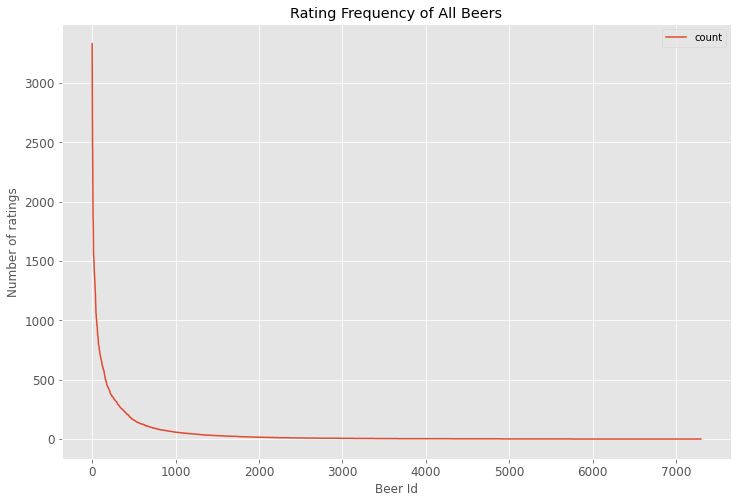

In [12]:
# plot rating frequency of all beers
ax = df_beer_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Beers',
        fontsize=12
    )
ax.set_xlabel("Beer Id")
ax.set_ylabel("Number of ratings")

Text(0, 0.5, 'Number of ratings (log scale)')

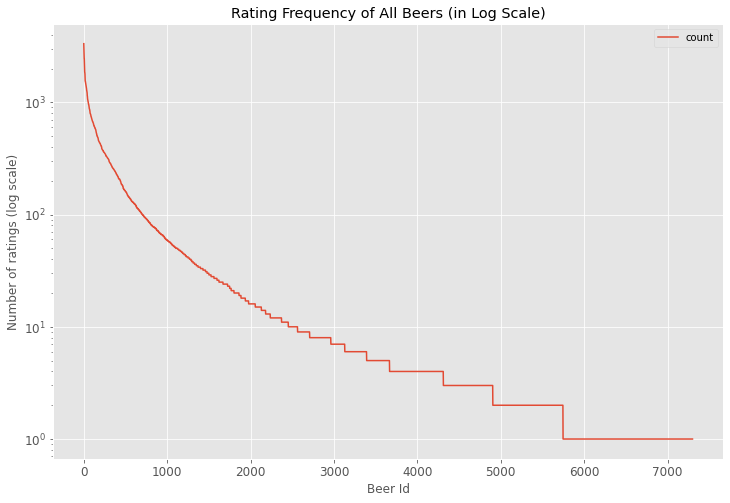

In [13]:
# plot rating frequency of all beers in log scale
ax = df_beer_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Beers (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("Beer Id")
ax.set_ylabel("Number of ratings (log scale)")

In [14]:
df_beer_cnt['count'].quantile(np.arange(1, 0.1, -0.05))

1.00    3330.00
0.95     250.05
0.90      95.00
0.85      51.00
0.80      31.00
0.75      20.00
0.70      13.00
0.65      10.00
0.60       8.00
0.55       6.00
0.50       5.00
0.45       4.00
0.40       3.00
0.35       3.00
0.30       2.00
0.25       2.00
0.20       1.00
0.15       1.00
Name: count, dtype: float64

In [15]:
# filter data
popularity_thres = 8
popular_beers = list(set(df_beer_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_beers = df_ratings[df_ratings.beer_beerid.isin(popular_beers)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular beers: ', df_ratings_drop_beers.shape)

shape of original ratings data:  (361241, 8)
shape of ratings data after dropping unpopular beers:  (349528, 8)


In [16]:
# get number of ratings given by every reviewer
df_reviewers_cnt = pd.DataFrame(df_ratings_drop_beers.groupby('review_profilename').size(), columns=['count'])
df_reviewers_cnt.head()

,count
review_profilename,
0110x011,27
01Ryan10,1
02maxima,2
04101Brewer,1
05Harley,38


Text(0, 0.5, 'number of ratings')

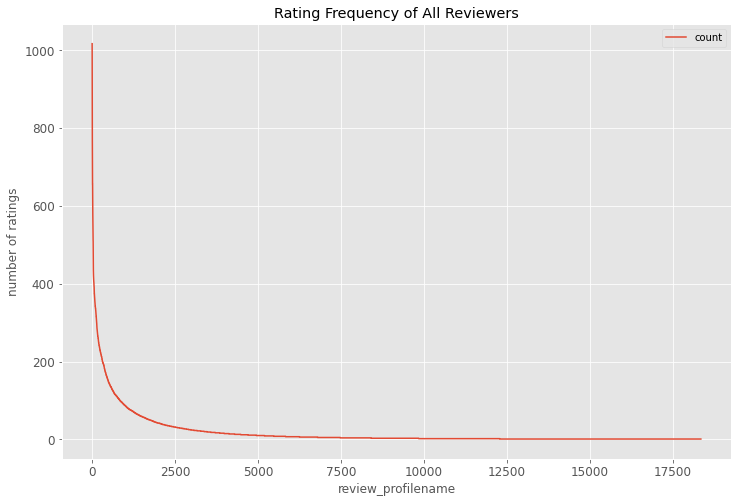

In [17]:
# plot rating frequency of all movies
ax = df_reviewers_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Reviewers',
        fontsize=12
    )
ax.set_xlabel("review_profilename")
ax.set_ylabel("number of ratings")

In [18]:
df_reviewers_cnt['count'].quantile(np.arange(1, 0.1, -0.05))


1.00    1017.0
0.95      93.0
0.90      47.0
0.85      28.0
0.80      18.0
0.75      12.0
0.70       8.0
0.65       6.0
0.60       5.0
0.55       4.0
0.50       3.0
0.45       2.0
0.40       2.0
0.35       2.0
0.30       1.0
0.25       1.0
0.20       1.0
0.15       1.0
Name: count, dtype: float64

In [19]:
# filter data
ratings_thres = 5
active_reviewers = list(set(df_reviewers_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_reviewers = df_ratings_drop_beers[df_ratings_drop_beers.review_profilename.isin(active_reviewers)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular beers and inactive reviewers: ', df_ratings_drop_reviewers.shape)

shape of original ratings data:  (361241, 8)
shape of ratings data after dropping both unpopular beers and inactive reviewers:  (330564, 8)


In [20]:
# pivot and create beer-reviewer matrix
beer_user_mat_overall = df_ratings_drop_reviewers.pivot_table(index='beer_beerid', columns='review_profilename', values='review_overall').fillna(0)
# create mapper from beer title to index
beer_to_idx = {
    beer: i for i, beer in 
    enumerate(list(df_beers_drop_duplicates.set_index('beer_beerid').loc[beer_user_mat_overall.index].beer_name))
}    
    
# transform matrix to scipy sparse matrix
beer_user_mat_sparse = csr_matrix(beer_user_mat_overall.values)

In [21]:
beer_user_mat_overall

review_profilename,0110x011,05Harley,0tt0,1000Bottles,100floods,11osixBrew,12vUnion,1759Girl,1Adam12,1fastz28,...,zoolzoo,zoso1967,zoso493,zplug123,zrab11,zseeanz,zsk,ztaylor1,zuffenhausen,zymurgy4all
beer_beerid,,,,,,,,,,,,,,,,,,,,,
67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,4.5,...,0.0,4.5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.5
142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(beer_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [23]:
def fuzzy_matching(mapper, fav_beer, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map beer title name to index of the beer in data

    fav_beer: str, name of user input beer
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for beer_name, idx in mapper.items():
        ratio = fuzz.ratio(beer_name.lower(), fav_beer.lower())
        if ratio >= 60:
            match_tuple.append((beer_name, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
        print(match_tuple)
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_beer, n_recommendations):
    """
    return top n similar beer recommendations based on user's input beer


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map beer title name to index of the beer in data

    fav_beer: str, name of user input beer

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar beer recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input beer:', fav_beer)
    idx = fuzzy_matching(mapper, fav_beer, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_beer))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [24]:
my_favorite = 'Smuttynose Octoberfest'

make_recommendation(
    model_knn=model_knn,
    data=beer_user_mat_sparse,
    fav_beer=my_favorite,
    mapper=beer_to_idx,
    n_recommendations=10)

You have input beer: Smuttynose Octoberfest
Found possible matches in our database: ['Portsmouth Octoberfest', 'Smuttynose Octoberfest (Big Beer Series)', 'Shiner Oktoberfest', 'Smuttynose Winter Ale', 'Smuttynose Robust Porter', 'Octoberfest', 'Ramstein Oktoberfest', "Smuttynose Rouge D'Shire", "McNeill's Oktoberfest", 'Tabernash Oktoberfest', 'Saint Arnold Oktoberfest', 'Smuttynose Portsmouth Lager', 'Sierra Nevada Octoberfest', 'Millstream Oktoberfest', 'Penn Oktoberfest', 'Point Oktoberfest', 'Frankenmuth Oktoberfest', 'Dunedin Oktoberfest Ale', 'Smuttynose Maibock (Big Beer Series)', 'Rauchtoberfest', 'Smuttynose Summer Weizen', 'Oktoberfest', 'Left Hand Oktoberfest', "Smuttynose S'muttonator (Big Beer Series)", 'Smuttynose IPA "Finest Kind"', "Bob's '47 Oktoberfest", 'Summit Oktoberfest Marzen', 'Smuttynose Old Brown Dog Ale']

[('Portsmouth Octoberfest', 780, 73), ('Smuttynose Octoberfest (Big Beer Series)', 15, 71), ('Shiner Oktoberfest', 2570, 70), ('Smuttynose Winter Ale', 12